In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import scipy.signal
import pickle


In [5]:

# we want to find B_i
# we do this by scrambling data in a 6 degree elevation angle band in the sky
# we can't use a histogram since there is spill over between bands (we want a sweep over the sky)

# Load up the IceCube data
icecube_data = np.load("./output_icecube_data.npz", allow_pickle=True)
data_sigmas = np.array(icecube_data["data_sigmas"])
data_ra = np.array(icecube_data["data_ra"])
data_dec = np.array(icecube_data["data_dec"])



<ipython-input-7-a8e11103120a>:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sweep_counts_norm, err = scipy.integrate.quad(f_sweep, -1.0, 1.0) # to normalize
No handles with labels found to put in legend.


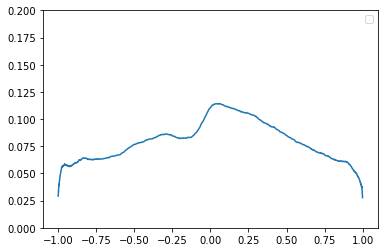

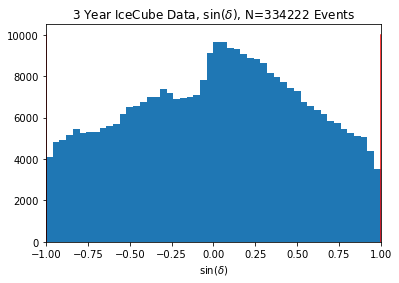

In [7]:

# remove events with no reported errors
data_ra = data_ra[data_sigmas != 0.0]
data_dec = data_dec[data_sigmas != 0.0]
data_sigmas = data_sigmas[data_sigmas != 0.0]

# convert the dec to a sine of dec, turns out to be useful in that format.
data_sin_dec = np.sin(data_dec)

N = float(len(data_sigmas))

# size of bins
size_of_band = np.deg2rad(3.0)

rad_ll = np.deg2rad(-87.0)
rad_ul = np.deg2rad(87.0)

# sweep over different sin decs to calculate the B_i at that point
sweep_dec = np.linspace(rad_ll, rad_ul, 1000)

sweep_counts = np.zeros(len(sweep_dec))
for i in range(len(sweep_dec)):
    solid_angle = 2.0 * np.pi * np.sin(size_of_band) * np.cos(sweep_dec[i])
    entries_in_band = np.abs(data_dec - sweep_dec[i]) < size_of_band
    total_in_band = np.sum(entries_in_band)
    sweep_counts[i] += total_in_band / solid_angle
    
f_sweep = scipy.interpolate.interp1d(np.sin(sweep_dec),
                                     sweep_counts,
                                     kind = 'cubic',
                                     bounds_error = False,
                                     fill_value = 0.0)

# to perform the average, integrate over result and divide it out
sweep_counts_norm, err = scipy.integrate.quad(f_sweep, -1.0, 1.0) # to normalize

# equation 2.2 in the paper
P_B = sweep_counts / sweep_counts_norm
B_i = P_B / (2.0 * np.pi)

np.savez("processed.npz", dec = sweep_dec, B_i = B_i)

plt.figure()
plt.plot(np.sin(sweep_dec), B_i)
plt.ylim(0.0, 0.2)
plt.legend()

# make a figure of the data sin dec, just a raw plot
plt.figure()
plt.title("3 Year IceCube Data, $\sin(\delta)$, N="+str(len(data_dec))+" Events")
plt.hist(data_sin_dec, range=(-1, 1), bins=50)
plt.xlabel("$\sin(\delta)$")
plt.xlim(-1.0, 1.0)
plt.plot([np.sin(rad_ll), np.sin(rad_ll)], [0.0, 10000.0], color="red")
plt.plot([np.sin(rad_ul), np.sin(rad_ul)], [0.0, 10000.0], color="red")


plt.show()